In [71]:
import pandas as pd
import numpy as np

# Operating System
import os

# https requests
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# Import Functions that we will be using

In [73]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_day_df(df_main, day_to_use=None):

    # Create new DataFrame for country-level analysis
    df_today = df_main.copy()
    
    # Aggregates suming the values for different states
    df_today = df_today.groupby(level = ['country', 'date']).sum().sort_index()

    # Drop unused columns
    df_today = df_today.drop(columns=['lat', 'long'])
    
    # Keep a signle date in the dataframe
    if day_to_use is None:
        day_to_use = df_today.index.get_level_values('date').max()
    

    idx = pd.IndexSlice
    df_today = df_today.loc[idx[:,day_to_use], :]    
    
    return df_today

In [112]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_country_df(df_main, country=None):
    
    # Create new DataFrame for single coubtry analysis
    df_country = df_main.copy()
    
    # Aggregates suming the values for different states
    df_country = df_country.groupby(level = ['country', 'date']).sum().sort_index()
    
    # Drop unused columns
    df_country = df_country.drop(columns=['lat', 'long'])
    
    # If a country was not provided retur None
    if country is None:
        return None
    
    # Keep a signle country in the dataframe and remove first two dates
    
    # Because of the .diff() operator, the faetures 'new_infections' and 'new_infections_increase'
    # have values of the previous country in the first two dates available for each country.
    first_date_to_use = df_country.index.get_level_values('date').min() + pd.Timedelta(days=2)
    
    idx = pd.IndexSlice
    df_country = df_country.loc[idx[country, first_date_to_use:], :] 
    
    return df_country


In [74]:
# Prints Last Day View plots 

def plot_today_figures(df_today, var_to_plot, pop=None, num_countries=10, min_pop = 1):
    
    df_plot = df_today[[var_to_plot]].copy()
    
    # save the last date and drop date index
    last_date_str = df_plot.index.get_level_values('date').max().strftime("%d-%b-%Y") 
    df_plot = df_plot.reset_index(level='date', drop=True)
    
    if pop is not None:
        
        # validade population DataFrame
        assert isinstance(pop, pd.DataFrame)
        assert pop.index.name == 'country'
        assert 'million_people' in pop.columns
        
        # merge with COVID DataFrame
        df_plot = pd.merge(df_plot, pop, how='inner', on='country', validate='one_to_one')
        
        # Create variable to plot formatted with correct units
        df_plot['plot_this'] = df_plot[var_to_plot] / df_plot['million_people']
        
        # Drop countries with less than min_pop population
        df_plot = df_plot.loc[df_plot.million_people > min_pop,:]
        
    else:
        df_plot['plot_this'] = df_plot[var_to_plot]

    
    
    # select top countries
    top_list = df_plot.loc[:, 'plot_this'].sort_values(ascending=False).iloc[:num_countries].index.tolist()
    
    if "portugal" not in top_list:
        top_list.append("portugal")
    
    # Format plot title
    plot_title_str = '{} on {}'.format(var_to_plot, last_date_str).replace('_', ' ').capitalize()
    if 'increase' in plot_title_str:
        plot_title_str += ' from previous day value' 
    
    # Format ylabel
    if pop is not None:
        y_lab = 'per million people'
    else:
        y_lab = 'total'
    
    # Format plot file name
    file_name_str = var_to_plot + '_' + y_lab.replace(' ', '_')
    
    # Plot
    df_plot.loc[top_list, ['plot_this']].plot.bar(figsize=(8,4))
    
    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel('[{}]'.format(y_lab))
    plt.xticks(rotation=25)
    
    plt.savefig(os.path.join('plots', file_name_str));

    
    return df_plot, top_list

In [75]:
# read world population DataFrame
df_population = pd.read_pickle('./data/df_population.pkl')

In [76]:
# read the complete COVID DataFrame
df_main = pd.read_pickle('./data/df_main.pkl')

In [77]:
idx = pd.IndexSlice

In [78]:
# Record last available date
last_date = df_main.index.get_level_values('date').max()

# Worldwide Day Summary

In [79]:
# Can test the output by changing the date
# df_world_today = df_main.loc[idx[:, :,"2020-03-21"], :].sum().drop(['lat', 'long'])
df_world_today = df_main.loc[idx[:, :,last_date], :].sum().drop(['lat', 'long'])
#df_world_today

In [80]:
str_to_print = "On {} there were {:,.0f} new infections reported worldwide, an increase of {:,.0f} new infections from the previous day, and {:,.0f} people died."
format_parameters_list = [last_date.strftime("%d-%b-%Y"), 
                          df_world_today['new_infections'],
                          df_world_today['new_infections_increase'],
                          df_world_today['new_deaths']
                         ]

print(str_to_print.format(*format_parameters_list))

On 25-Mar-2020 there were 49,548 new infections reported worldwide, an increase of 9,738 new infections from the previous day, and 2,555 people died.


In [82]:
str_to_print = "Until {}, {:,.0f} people have been reported infected, and {:,.0f} people have died."
format_parameters_list = [last_date.strftime("%d-%b-%Y"), 
                          df_world_today['total_infections'],
                          df_world_today['total_deaths']
                         ]

print(str_to_print.format(*format_parameters_list))

Until 25-Mar-2020, 467,593 people have been reported infected, and 21,180 people have died.


# Last Day View

In [83]:
# Build today country-level DataFrame
df_today = build_single_day_df(df_main)

In [86]:
list_of_countries = ["portugal", "spain", "italy"]

# # Uncomment to confirm results
# df_main.loc[idx[list_of_countries, :, last_date - pd.Timedelta(days=2) :last_date], :]

In [87]:
# # Uncomment to confirm results
# df_today.loc[idx[list_of_countries,:],:]

## New Infections  

This variable describes the flow of people into the *infected reservoir*, i.e. how many people a day are testing positive for the infection. It assesses the *speed* people are entering into the *infected pool*.

In each plot, we include the top-10 countries plus Portugal (if not in the top-10).

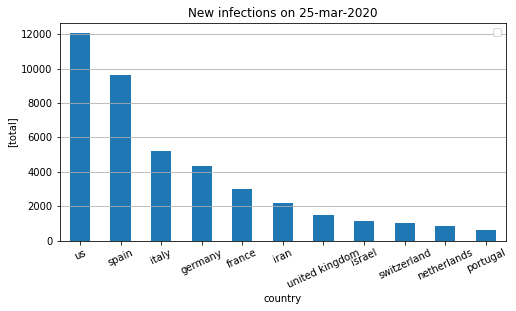

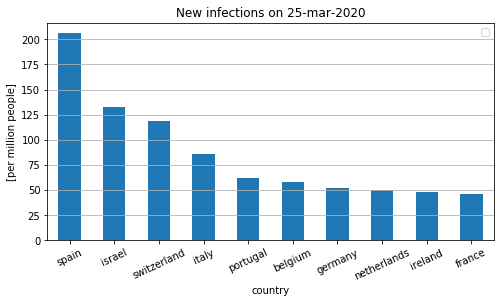

In [88]:
var_to_plot = 'new_infections'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

## New Infections Increase  

To assess whether the number of people in the *infected reservoir* is increasing or decreasing, a better proxy is the variation of the previous variable.  

Every new infection will, sooner or later, leave the *infected pool* (either by recover or death). In this way, if the number of new infections stabilizes, the same will happen, sooner or later, to the total number of people in the *infected reservoir*.


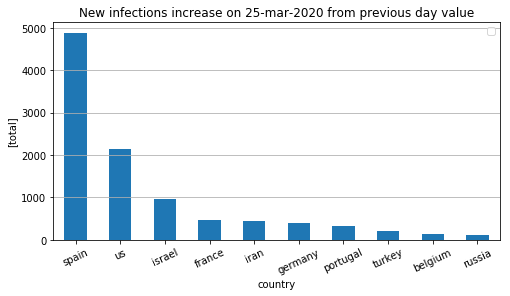

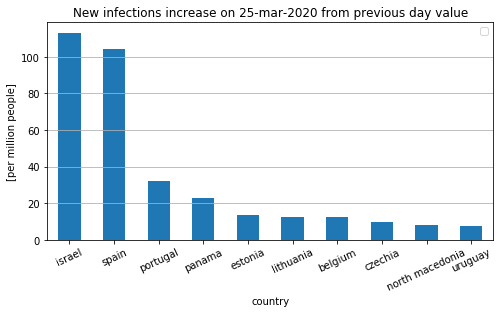

In [92]:
var_to_plot = 'new_infections_increase'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

# Aggregate Total View  

The total number of infections and deaths, until the last available date.

## Total Number of Infections

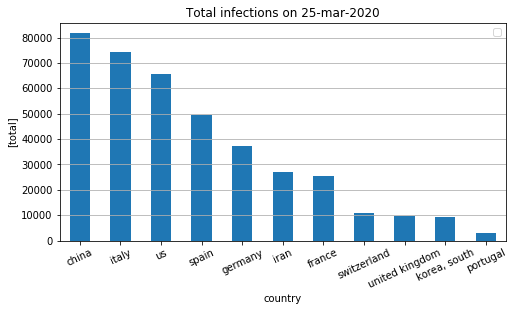

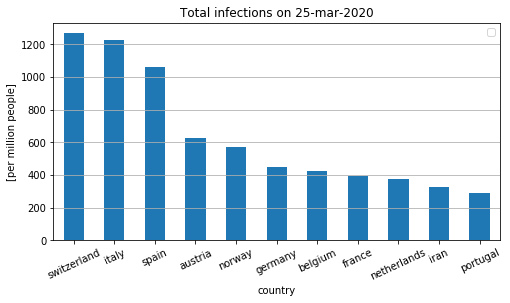

In [89]:
var_to_plot = 'total_infections'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)


## Total Number of Deaths

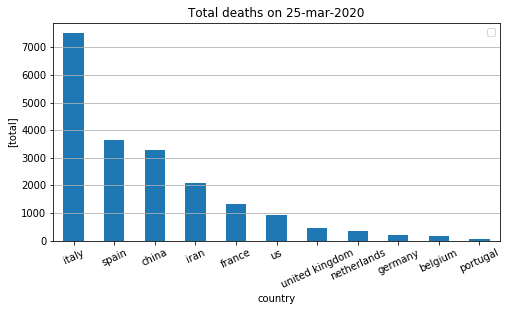

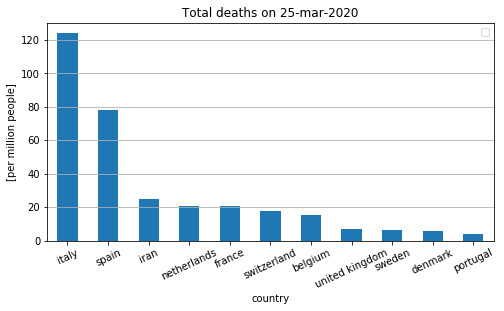

In [90]:
var_to_plot = 'total_deaths'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

# Single Country Time-Trend  

Evolution since the day of the 100th reported infection.

We plot new infections in log scale
New infections daily growth rate, simple and 7 days moving average.



In [ ]:
plot_today_figures(df_today, var_to_plot, pop=None, num_countries=10, min_pop = 1):
    
    df_plot = df_today[[var_to_plot]].copy()
    
    # save the last date and drop date index
    last_date_str = df_plot.index.get_level_values('date').max().strftime("%d-%b-%Y") 
    df_plot = df_plot.reset_index(level='date', drop=True)
    
    if pop is not None:
        
        # validade population DataFrame
        assert isinstance(pop, pd.DataFrame)
        assert pop.index.name == 'country'
        assert 'million_people' in pop.columns
        
        # merge with COVID DataFrame
        df_plot = pd.merge(df_plot, pop, how='inner', on='country', validate='one_to_one')
        
        # Create variable to plot formatted with correct units
        df_plot['plot_this'] = df_plot[var_to_plot] / df_plot['million_people']
        
        # Drop countries with less than min_pop population
        df_plot = df_plot.loc[df_plot.million_people > min_pop,:]
        
    else:
        df_plot['plot_this'] = df_plot[var_to_plot]

    
    
    # select top countries
    top_list = df_plot.loc[:, 'plot_this'].sort_values(ascending=False).iloc[:num_countries].index.tolist()
    
    if "portugal" not in top_list:
        top_list.append("portugal")
    
    # Format plot title
    plot_title_str = '{} on {}'.format(var_to_plot, last_date_str).replace('_', ' ').capitalize()
    if 'increase' in plot_title_str:
        plot_title_str += ' from previous day value' 
    
    # Format ylabel
    if pop is not None:
        y_lab = 'per million people'
    else:
        y_lab = 'total'
    
    # Format plot file name
    file_name_str = var_to_plot + '_' + y_lab.replace(' ', '_')
    
    # Plot
    df_plot.loc[top_list, ['plot_this']].plot.bar(figsize=(8,4))
    
    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel('[{}]'.format(y_lab))
    plt.xticks(rotation=25)
    
    plt.savefig(os.path.join('plots', file_name_str));

    
    return df_plot, top_list

In [161]:
def make_the_plot(df_plot, var_to_plot=None, log=False, pct_change=False ,rolling=False):
    
    if var_to_plot is None:
        print("make_the_plot(): no variable was defined")
        return
    
    ts = df_plot[var_to_plot]
    
    ts.plot(figsize=(8,4), marker='D', markersize=4, logy=log)

    plt.grid(axis='y')
    plt.legend()

    #plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
    plt.ylabel('')
    plt.show();
    
    return



def plot_country_figures(df_country, min_num_cases = 100):
    
    df_plot = df_country.copy()
    
    # drop values before the number of comfirmed cases exceeds a minimum number of cases (min_num_cases)
    first_date = df_plot.loc[ df_plot.total_infections > min_num_cases, :].index.get_level_values('date')[0]
    
    idx = pd.IndexSlice
    df_plot = df_plot.loc[idx[:, first_date:], :]
    
    # Save country name and remove it from the DataFrame index
    country_name = df_plot.index.get_level_values('country')[0]
    
    df_plot = df_plot.reset_index(level='country', drop=True)
    
    
    make_the_plot(df_plot, var_to_plot='new_infections', log=True, pct_change=False, rolling=False)
    
    
    return df_plot

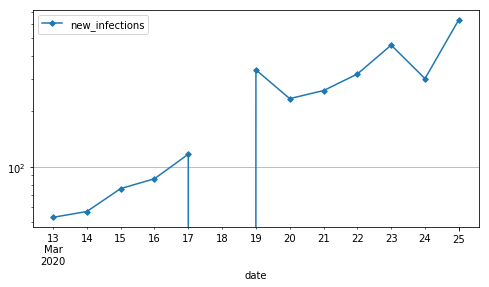

,total_infections,new_infections,new_infections_increase,recovered,total_deaths,new_deaths
date,,,,,,
2020-03-13,112,53.0,53.0,1.0,0,0.0
2020-03-14,169,57.0,4.0,2.0,0,0.0
2020-03-15,245,76.0,19.0,2.0,0,0.0
2020-03-16,331,86.0,10.0,3.0,0,0.0
2020-03-17,448,117.0,31.0,3.0,1,1.0
2020-03-18,448,0.0,-117.0,3.0,2,1.0
2020-03-19,785,337.0,337.0,3.0,3,1.0
2020-03-20,1020,235.0,-102.0,5.0,6,3.0
2020-03-21,1280,260.0,25.0,5.0,12,6.0


In [162]:
plot_country_figures(df_country)

## Portugal

In [117]:
country = "portugal"
df_country = build_single_country_df(df_main, country)

plot_country_figures
for parameters_tuple in [('new_infections', 'yes', '')]

In [122]:
df_country.loc[ df_country.total_infections > 100, :].index.get_level_values('date')[0]

Timestamp('2020-03-13 00:00:00')

In [ ]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
plt.ylabel('');

### Merge with country population

In [228]:
# df_aux = pd.merge(df_today, df_population, how='left', on='country', validate='one_to_one')
# df_aux

new_infections_increase_per_million_people


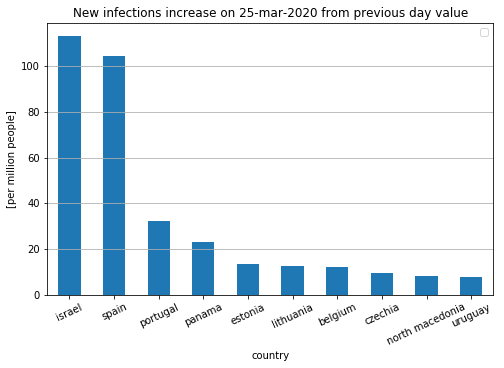

In [440]:
df_aux, top_list = plot_today_figures(df_today, 'new_infections_increase', pop=df_population)

new_infections_total
new_infections_increase_total


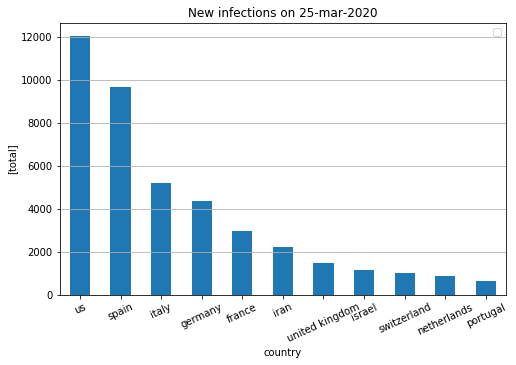

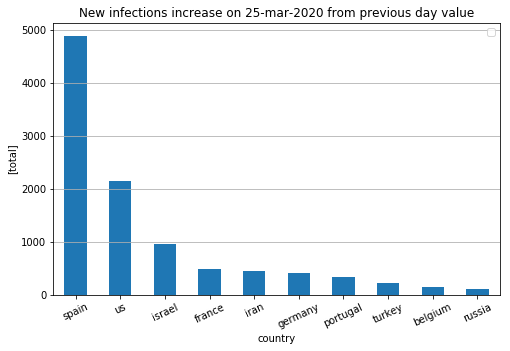

In [458]:
for var_to_plot in ['new_infections', 'new_infections_increase']:
    plot_today_figures(df_today, var_to_plot, pop=None)

In [389]:
df_aux.sort_values(by='plot_this',ascending=False)

,new_infections,million_people,plot_this
country,,,
spain,9630.0,46.736776,206.047589
israel,1131.0,8.519377,132.756186
switzerland,1020.0,8.591365,118.723858
italy,5210.0,60.550075,86.044485
portugal,633.0,10.226187,61.899905
belgium,668.0,11.539328,57.888986
germany,4337.0,83.517045,51.929519
netherlands,858.0,17.097130,50.183861
ireland,235.0,4.882495,48.131130


In [351]:
df_aux.loc[top_list, var_to_plot]

country
us                12038.0
spain              9630.0
italy              5210.0
germany            4337.0
france             2978.0
iran               2206.0
united kingdom     1476.0
israel             1131.0
switzerland        1020.0
netherlands         858.0
portugal            633.0
Name: new_infections, dtype: float64

In [354]:
df_aux.loc[:, ['new_infections']].div(df_aux.million_people)

,afghanistan,albania,algeria,andorra,angola,antigua and barbuda,argentina,armenia,australia,austria,...,ukraine,united arab emirates,united kingdom,uruguay,us,uzbekistan,venezuela,vietnam,zambia,zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antigua and barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
isinstance(df_aux, pd.DataFrame)

True

In [331]:
df_population.index.name == 'country'

True

In [ ]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [ ]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

### Choose variable

In [629]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [630]:
# choose data format: total or new
data_format = "new"

---

In [631]:
# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [633]:
# If analysis of new cases compute difference from previous day
if data_format == "new":
    df_today.loc[:,['confirmed', 'recovered', 'deaths']] = df_today.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

In [634]:
# select last available date
last_date = df.date.drop_duplicates().sort_values().iloc[-1]
last_date

Timestamp('2020-03-23 00:00:00')

In [635]:
df_today = df_today.loc[df_today.date == last_date,: ].reset_index(drop=True)
df_today = df_today.loc[:, ['date', 'country', 'confirmed', 'recovered', 'deaths']]

In [636]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

In [637]:
# select top-level countries plus portugal
top_number = 10
top_list = cs_countries.sort_values(ascending=False).iloc[:top_number].index.tolist()

if "portugal" not in top_list:
    top_list.append("portugal")

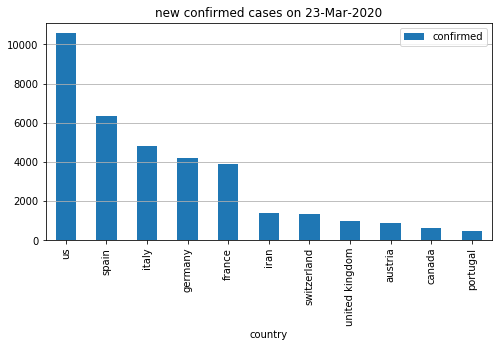

In [638]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [639]:
df_today

,date,country,confirmed,recovered,deaths
0,2020-03-23,afghanistan,0.0,0.0,0.0
1,2020-03-23,albania,15.0,0.0,2.0
2,2020-03-23,algeria,29.0,0.0,0.0
3,2020-03-23,andorra,20.0,0.0,0.0
4,2020-03-23,angola,1.0,0.0,0.0
5,2020-03-23,antigua and barbuda,2.0,0.0,0.0
6,2020-03-23,argentina,35.0,0.0,0.0
7,2020-03-23,armenia,41.0,0.0,0.0
8,2020-03-23,australia,13.0,0.0,0.0
9,2020-03-23,australia,0.0,0.0,0.0


In [642]:
pd.merge(df_today, df_population, how='left', on='country', validate='many_to_one')

,date,country,confirmed,recovered,deaths,year,million_people
0,2020-03-23,afghanistan,0.0,0.0,0.0,2019.0,38.041754
1,2020-03-23,albania,15.0,0.0,2.0,2019.0,2.880917
2,2020-03-23,algeria,29.0,0.0,0.0,2019.0,43.053054
3,2020-03-23,andorra,20.0,0.0,0.0,2019.0,0.077142
4,2020-03-23,angola,1.0,0.0,0.0,2019.0,31.825295
5,2020-03-23,antigua and barbuda,2.0,0.0,0.0,2019.0,0.097118
6,2020-03-23,argentina,35.0,0.0,0.0,2019.0,44.780677
7,2020-03-23,armenia,41.0,0.0,0.0,2019.0,2.957731
8,2020-03-23,australia,13.0,0.0,0.0,2019.0,25.203198
9,2020-03-23,australia,0.0,0.0,0.0,2019.0,25.203198


2

In [ ]:
pd.merge(df_clean, df_hospitais_codes, how='left', on='clean_name', validate='many_to_one')

---

# Single country analysis - time series

### Choose country, state

In [549]:
# choose country
country = "spain"

# choose state
state = ""

### Choose variable

In [550]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [551]:
# choose data format: total or new
data_format = "new"

---

In [552]:
# Confirm aceptable values for country and state
assert country in df.country.values
assert state in df.loc[df.country==country].state.values

# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [553]:
# same DataFrame but only for one country
df_country = df.loc[(df.country==country) & (df.state==state)].reset_index(drop = True).sort_values(by='date')

# confirm that we have only one observation per day
assert df_country.date.duplicated().sum() == 0

# set data as DataFrame index
df_country = df_country.set_index('date')

In [555]:
# drop values before the number of comfirmed cases exceeds a minimum number of cases (min_num_cases)
min_num_cases = 1000

first_date = df_country['confirmed'].loc[df_country['confirmed'] > min_num_cases].index[0]
#first_date

In [556]:
if data_format == "new":
    df_country.loc[:,['confirmed', 'recovered', 'deaths']] = df_country.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

### time-trend plot

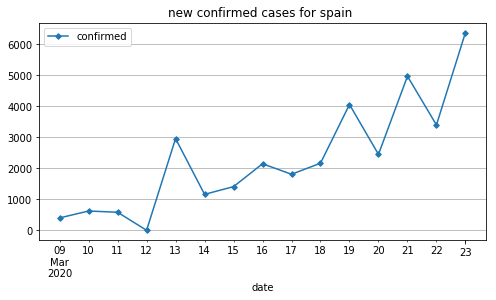

In [557]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
plt.ylabel('');

### time-trend plot (log scale)

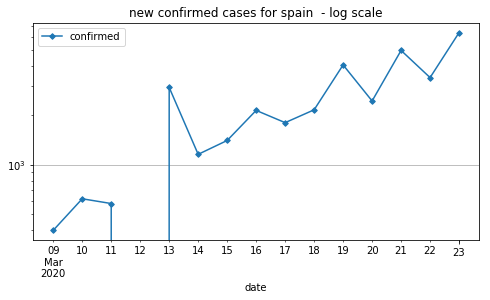

In [559]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4, logy=True)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - log scale'.format(data_format, variable, country, state))
plt.ylabel('');

### daily growth rate

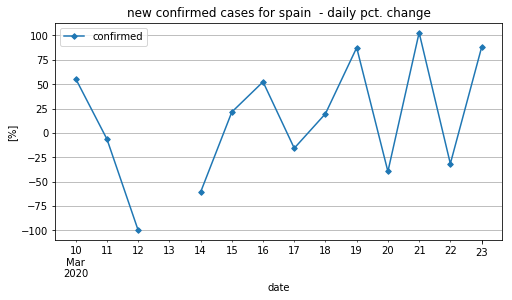

In [560]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change'.format(data_format, variable, country, state))
plt.ylabel('[%]');

### daily growth rate - rolling mean

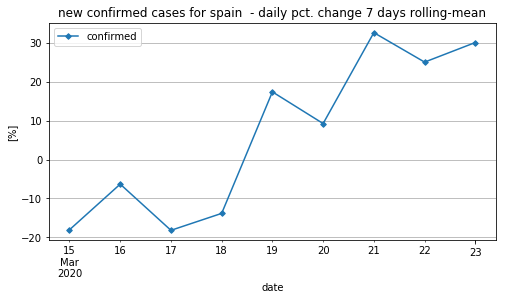

In [561]:
num_days = 7

plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).rolling(num_days, min_periods=num_days-2).mean().plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change {} days rolling-mean'.format(data_format, variable, country, state, num_days))
#plt.title('Daily pct. change of {} cases for {} {} - {} days rolling-mean'.format(variable, country, state, num_days))
plt.ylabel('[%]');


---

### Nº of days to double cases

In [241]:
daily_growth = 0.05

In [242]:
num_days_to_double = (np.log(2))/(np.log(1+daily_growth))
num_days_to_double

14.206699082890463

In [94]:
x =np.arange(0,30,1)
y = 1000*(1+0.1)**x

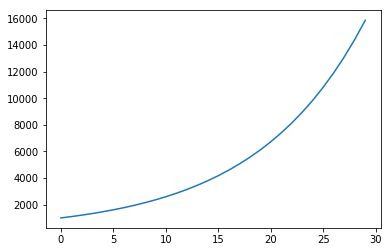

In [95]:
plt.plot(x, y);

In [97]:
ys = pd.Series(y)

In [98]:
ys.pct_change()

0     NaN
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

In [99]:
ys.diff().pct_change()

0     NaN
1     NaN
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

In [587]:
ys.diff().pct_change()

0     NaN
1     NaN
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

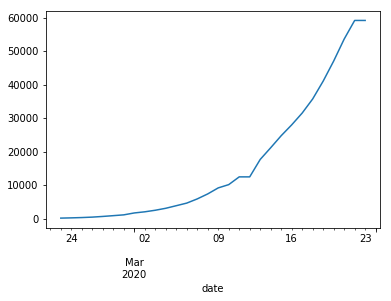

In [10]:
s.plot()

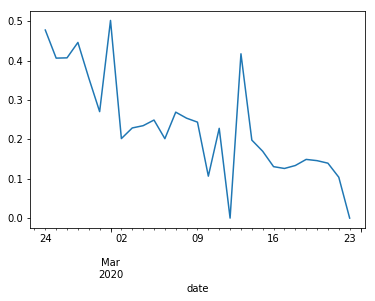

In [11]:
s.pct_change().plot()

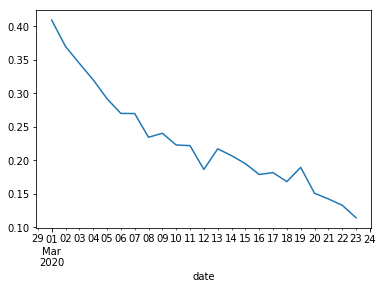

In [12]:
s.pct_change().rolling(7).mean().plot()

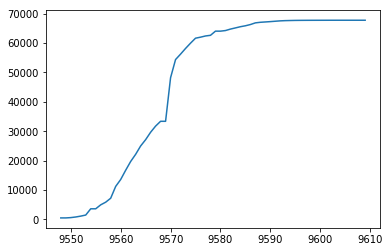

In [13]:
df.loc[(df.country=="China") & (df.state=="Hubei"),:].confirmed.plot()